In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from models import SingleBVPNet, CropConvNeuralProcess, Discriminator, TripletNet
from modules import RGAN, Reconstruction
import torch
import numpy as np
from PIL import Image, ImageOps
import dataio
from dataio import get_mgrid
import torch.nn as nn
import scipy
from pycocotools.coco import COCO
import loss_functions
import os
import skimage.io as io
import matplotlib.pyplot as plt
from functools import partial
import yaml
from glob import glob
from copy import deepcopy
import torchvision.models as models
import cv2

In [9]:
class TextureDataset(Dataset):
    def __init__(self, config, transform, part):
        self.part = part
        if self.part == "train":
            self.root_dir = config['data']['train_dir']
        else:
            self.root_dir = config['data']['val_dir']
        self.image_size = config['data']['image_size']
        self.after_crop_size = config['data']['after_crop_size']
        self.center = self.after_crop_size // 2
        self.cv = self.after_crop_size // 4
        
        self.image_type = config['data']['image_type']
        self.transform = transform
        self.img_channels = 1
        
        self.rotate = transforms.Compose([
            transforms.RandomRotation(90)
        ])
        
        self.crop = transforms.Compose([
            transforms.CenterCrop(self.after_crop_size)
        ])
        
        self.file_list = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                self.file_list.append(os.path.join(root, file))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        X = dict()
        img_path = self.file_list[idx]
        rivet = Image.open(img_path).resize((self.image_size, self.image_size))
        rotated = deepcopy(rivet)
        
        rivet = self.crop(rivet)
        rotated = self.rotate(rotated)
        rotated = self.crop(rotated)
        
        croped = self.crop(rotated)
        
        if self.image_type == "Corrupted":
            rivet = np.array(rivet)
            full_rivet = deepcopy(rivet)
            center_rivet = deepcopy(rivet[self.center - self.cv: self.center + self.cv, self.center - self.cv: self.center + self.cv])
            rivet[self.center - self.cv: self.center + self.cv, self.center - self.cv: self.center + self.cv] = 0.0
            cropped = deepcopy(rivet)
            
            rivet = Image.fromarray(rivet)
            cropped = Image.fromarray(cropped)
            full_rivet = Image.fromarray(full_rivet)
            center_rivet = center_rivet.astype(np.uint8)
            center_rivet = Image.fromarray(center_rivet)
                
        elif self.image_type == "TriMir":
            rivet = tri_mirror(rivet, self.center, self.cv)
            
        rivet = self.transform(rivet)
        cropped = self.transform(cropped)
        full_rivet = self.transform(full_rivet)
        center_rivet = self.transform(center_rivet)
        rotated = self.transform(rotated)
        
        center_rivet = center_rivet.unsqueeze(0)

        X['Rivet'] = rivet
        X['Center'] = center_rivet
        X['Rotated'] = rotated
        X['Full'] = full_rivet
        X['Crop'] = cropped
        return X

class Implicit2DWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, sidelength=None, compute_diff=None):

        if isinstance(sidelength, int):
            sidelength = (sidelength, sidelength)
        self.sidelength = sidelength

        self.compute_diff = compute_diff
        self.dataset = dataset
        self.mgrid = get_mgrid(sidelength)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        borders = item['Rivet']
        img = item['Center']
        full_rivet = item['Full']
        cropped = item['Crop']
        rotated = item['Rotated']

        if self.compute_diff == 'gradients':
            img *= 1e1
            gradx = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
            grady = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        elif self.compute_diff == 'laplacian':
            img *= 1e4
            laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        elif self.compute_diff == 'all':
            gradx = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
            grady = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
            laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        
        
        img = img.squeeze(0)
        img = img.permute(1, 2, 0).view(-1, self.dataset.img_channels)

        in_dict = {'idx': idx, 'coords': self.mgrid, "border": borders, 'rotated': rotated}
        gt_dict = {'img': img, 'full': full_rivet, 'crop': cropped}
#         gt_dict = {'img': img}

        if self.compute_diff == 'gradients':
            gradients = torch.cat((torch.from_numpy(gradx).reshape(-1, 1),
                                   torch.from_numpy(grady).reshape(-1, 1)),
                                  dim=-1)
#             dataio.grads2img(dataio.lin2img(gt['gradients'])).permute(1, 2, 0).squeeze().detach().cpu().numpy()
            gt_dict.update({'gradients': gradients})

        elif self.compute_diff == 'laplacian':
            gt_dict.update({'laplace': torch.from_numpy(laplace).view(-1, 1)})

        elif self.compute_diff == 'all':
            gradients = torch.cat((torch.from_numpy(gradx).reshape(-1, 1),
                                   torch.from_numpy(grady).reshape(-1, 1)),
                                  dim=-1)
            gt_dict.update({'gradients': gradients})
            gt_dict.update({'laplace': torch.from_numpy(laplace).view(-1, 1)})

        return in_dict, gt_dict

    def get_item_small(self, idx):
        img = self.dataset[idx]
        spatial_img = img.clone()
        img = img.permute(1, 2, 0).view(-1, self.dataset.img_channels)

        gt_dict = {'img': img}

        return spatial_img, img, gt_dict

In [10]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])

dataset = TextureDataset(config, transform, "val")
coord_dataset = Implicit2DWrapper(dataset, sidelength=config['data']['after_crop_size']//2, compute_diff='all')
dataloader = DataLoader(coord_dataset, batch_size=1, shuffle=True, num_workers=0)

In [11]:
image_resolution = config['data']['after_crop_size']//2
in_features = 8194
model = RGAN(config)

SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=514, out_features=1024, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (5): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (6): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)


In [12]:
new_model = Reconstruction.load_from_checkpoint(checkpoint_path="lightning_logs/version_59/checkpoints/N-Step-Checkpoint_epoch=99000_global_step=99000.ckpt", config=config).cuda()

SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=514, out_features=1024, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (5): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (6): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)


In [13]:
cos = nn.PairwiseDistance()
# cos = nn.CosineSimilarity(dim=1, eps=1e-6)
triplet = nn.TripletMarginWithDistanceLoss(margin=0.1)
loss_fn = partial(loss_functions.image_mse, None)

ModuleAttributeError: 'Reconstruction' object has no attribute 'discriminator'

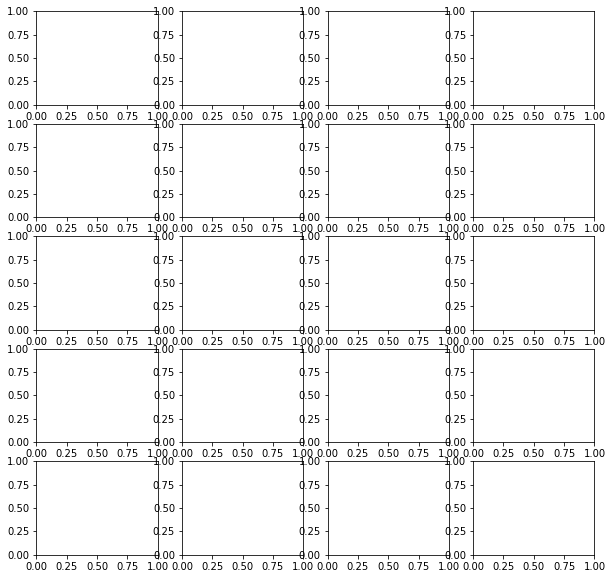

In [14]:
fig,axes = plt.subplots(nrows = 5, ncols = 4, figsize=(10,10))
center = 64 // 2
cv = 64 // 4
for step, (model_input, gt) in enumerate(dataloader):
    model_input = {key: value.cuda() for key, value in model_input.items()}
    gt = {key: value.cuda() for key, value in gt.items()}
    model_output = new_model.generator(model_input)
    full_img = gt['full'].cpu().numpy()[0][0]
    cropped = gt['crop'].cpu().numpy()[0][0]
    pred_img = dataio.lin2img(model_output['model_out'], image_resolution).detach().cpu().numpy()[0][0]
    input_pred = deepcopy(cropped)
    input_pred[center - cv: center + cv, center - cv: center + cv] = pred_img
    d_full = torch.from_numpy(full_img).unsqueeze(0).unsqueeze(0).cuda()
    d_pred = torch.from_numpy(input_pred).unsqueeze(0).unsqueeze(0).cuda()
    
    full_score = new_model.get_embedding(d_full)
    pred_score = new_model.get_embedding(d_pred)
    rotated_score = new_model.get_embedding(model_input['rotated'])
    
    positive_cosine = cos(pred_score, rotated_score)
    negative_cosine = cos(full_score, rotated_score)
    gt_cosine = cos(full_score, pred_score)
    mse = loss_fn(model_output, gt)['img_loss']
    
    print(f"Image {step}")
    print(f"Pred-Rotated Cosine sim: {positive_cosine[0] * 1000}")
    print(f"GT-Rotated Cosine sim: {negative_cosine[0] * 1000}")
    print(f"GT-Pred Cosine sim: {gt_cosine[0] * 1000}")
    print(f"MSE: {mse}")
    
    axes[step][0].imshow(full_img, cmap='gray')
    axes[step][1].imshow(cropped, cmap='gray')
    cropped[center - cv: center + cv, center - cv: center + cv] = pred_img
    diff = np.absolute(full_img - cropped)
    score = np.sum(diff)
    axes[step][2].imshow(cropped, cmap='gray')
    axes[step][3].imshow(model_input['rotated'].squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
    if step == 4:
        break

In [228]:
image_size = 80
center = 64 // 2
cv = 64 // 4

rotate = transforms.Compose([
            transforms.RandomRotation(90)])

crop = transforms.Compose([
            transforms.CenterCrop(64)])

transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

In [229]:
X = dict()
rivet = Image.open("gray.jpg").resize((image_size, image_size))
rotated = deepcopy(rivet)

rivet = crop(rivet)
rotated = rotate(rotated)
rotated = crop(rotated)

croped = crop(rotated)


rivet = np.array(rivet)
full_rivet = deepcopy(rivet)
center_rivet = deepcopy(rivet[center - cv: center + cv, center - cv: center + cv])
rivet[center - cv: center + cv, center - cv: center + cv] = 0.0
cropped = deepcopy(rivet)

rivet = Image.fromarray(rivet)
cropped = Image.fromarray(cropped)
full_rivet = Image.fromarray(full_rivet)
center_rivet = center_rivet.astype(np.uint8)
center_rivet = Image.fromarray(center_rivet)

rivet = transform(rivet)
cropped = transform(cropped)
full_rivet = transform(full_rivet)
center_rivet = transform(center_rivet)
rotated = transform(rotated)

center_rivet = center_rivet.unsqueeze(0)

X['Rivet'] = rivet
X['Center'] = center_rivet
X['Rotated'] = rotated
X['Full'] = full_rivet
X['Crop'] = cropped

In [230]:
borders = X['Rivet']
img = X['Center']
full_rivet = X['Full']
cropped = X['Crop']
rotated = X['Rotated']

In [231]:
img = img.squeeze(0)
img = img.permute(1, 2, 0).view(-1, 1).cuda()

In [232]:
mgrid = get_mgrid((32))

In [233]:
in_dict = {'idx': 0, 'coords': mgrid.unsqueeze(0).cuda(), "border": borders.unsqueeze(0).cuda(), 'rotated': rotated.unsqueeze(0).cuda()}

In [234]:
model_output = new_model.generator(in_dict)

In [235]:
pred_img = dataio.lin2img(model_output['model_out'], 32).squeeze(0).squeeze(0).detach().cpu().numpy()

In [236]:
print(cropped.shape)

torch.Size([1, 64, 64])


In [237]:
input_pred = deepcopy(cropped[0]).numpy()
input_pred[center - cv: center + cv, center - cv: center + cv] = pred_img

In [240]:
input_pred.shape

(64, 64)

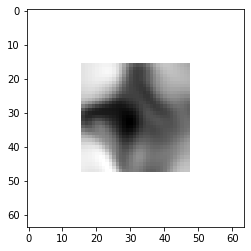

In [242]:
plt.imshow(input_pred, cmap='gray')

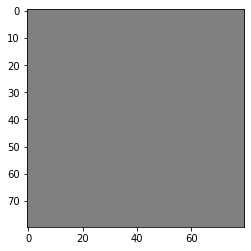

In [243]:
rivet = Image.open("gray.jpg").resize((image_size, image_size))
plt.imshow(rivet)